## Libraries

In [41]:
#import necessary libraries 

import os 
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Normalize
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Pre-Trained Model
import torchvision.models as models

# Load ResNet-50 model
model = models.resnet50(pretrained=True)

/Users/angelmurillo/Desktop/ML Projects/melanoma_pytorch_transfer_learning/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/angelmurillo/Desktop/ML Projects/melanoma_pytorch_transfer_learning/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Checking ResNet Architecture

In [42]:
print(model)

# out_features=1000 so need to chage to 2 for classification task

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Modify ResNet to fit Data

In [43]:
class ModifiedResNet(nn.Module):
    def __init__(self):
        super(ModifiedResNet, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)
        num_classes = 2  # benign or malignant
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # changing final fully connected layer for 2 classes

    def forward(self, x):
        return self.resnet(x)

model_modified = ModifiedResNet()

Using cache found in /Users/angelmurillo/.cache/torch/hub/pytorch_vision_main


## Freezing Pre-Trained Layers

In [44]:
for param in model_modified.parameters():
    param.requires_grad = False
    # this step is setting gradient calculation during back propagation set to false for the pre-trained layers

## Data Pre-Processing and EDA

In [45]:
import numpy as np

# Data directory
data_dir = '/Users/angelmurillo/Desktop/ML Projects/melanoma_pytorch_transfer_learning/data2'

# Define transforms needed for images to be compatible with ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the datasets
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
test_dataset = ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

# Print class to index mapping
print(train_dataset.class_to_idx)

# Split the train set further into train and validation:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


{'benign': 0, 'malignant': 1}
Training set size: 523
Validation set size: 131
Test set size: 472


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5604358..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8256302..2.0776608].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


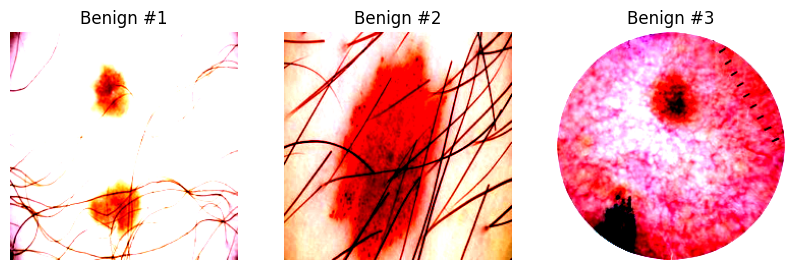

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7556022..2.1804092].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3687146..1.6465361].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7205882..2.4134207].


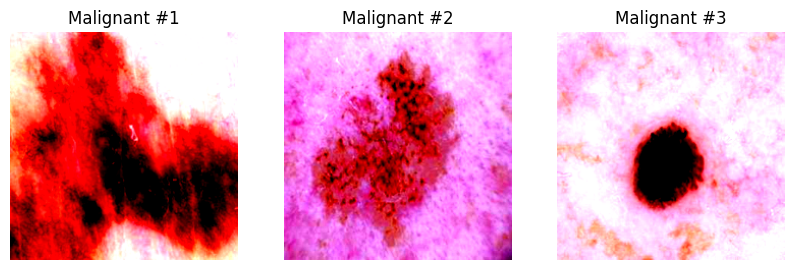

In [48]:
# Extract all images and labels from the train dataset
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Function to plot images
def plot_images(images, labels, title):
    plt.figure(figsize=(10, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Convert from Tensor image to numpy array
        plt.title(f'{title} #{i+1}')
        plt.axis('off')
    plt.show()

# Find indices of benign and malignant examples
benign_indices = [i for i, label in enumerate(labels) if label == 0][:3]
malignant_indices = [i for i, label in enumerate(labels) if label == 1][:3]

# Plot benign examples
plot_images([images[i] for i in benign_indices], [labels[i] for i in benign_indices], 'Benign')

# Plot malignant examples
plot_images([images[i] for i in malignant_indices], [labels[i] for i in malignant_indices], 'Malignant')

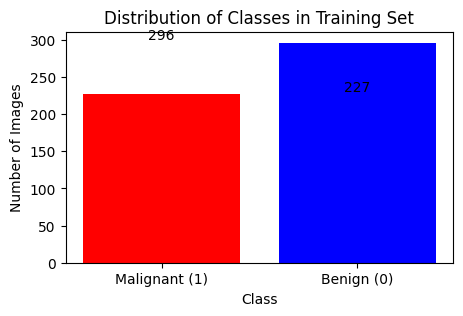

In [49]:
from collections import Counter

# Count the occurrences of each class
class_counts = Counter(label for _, label in train_dataset)

# Create lists for the plot
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create the plot
plt.figure(figsize=(5, 3))
plt.bar(classes, counts, color=['blue', 'red'])
plt.title('Distribution of Classes in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')

# Add the actual count on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Add labels for each class
plt.xticks(classes, ['Benign (0)', 'Malignant (1)'])

# Show the plot
plt.show()

no major class imbalance observed, can continue with training.

# Setting Up Model Parameters & Training

In [50]:
# Unfreeze the last layer (layer4) and the final fully connected layer
for param in model_modified.resnet.layer4.parameters():
    param.requires_grad = True
for param in model_modified.resnet.fc.parameters():
    param.requires_grad = True

## Train the Model

In [51]:
# Set up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the appropriate device
model_modified = model_modified.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_modified.parameters(), lr=0.001)
num_epochs = 5

# Lists to store losses and accuracies for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model_modified.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_modified(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = train_correct / train_total
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Validation loop 
    model_modified.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_modified(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_running_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

print('Finished fine-tuning')


Using device: cpu
Epoch 1/5, Loss: 0.4513, Accuracy: 0.8489
Validation Loss: 12.4104, Validation Accuracy: 0.6412
Epoch 2/5, Loss: 0.1294, Accuracy: 0.9541
Validation Loss: 0.8858, Validation Accuracy: 0.9466
Epoch 3/5, Loss: 0.0622, Accuracy: 0.9771
Validation Loss: 0.1296, Validation Accuracy: 0.9618
Epoch 4/5, Loss: 0.0497, Accuracy: 0.9828
Validation Loss: 0.4025, Validation Accuracy: 0.8779
Epoch 5/5, Loss: 0.0796, Accuracy: 0.9675
Validation Loss: 0.3359, Validation Accuracy: 0.9237
Finished fine-tuning


## Training Results

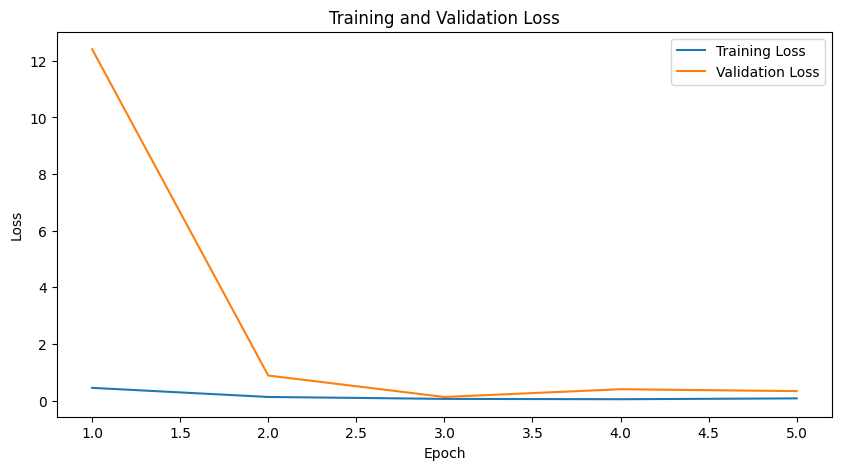

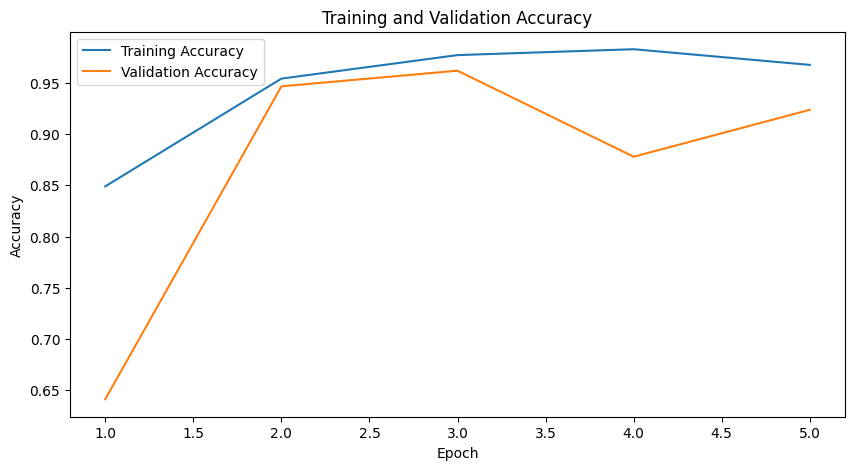

In [52]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Inference 

In [53]:
from PIL import Image

# Set up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load trained model
model_modified.eval() 

# Load and preprocess the image
img_path = '/Users/angelmurillo/Desktop/ML Projects/melanoma_pytorch_transfer_learning/data/test/malignant/melanoma_10600.jpg'
image = Image.open(img_path)
example_img = transform(image).unsqueeze(0)  # Add batch dimension

# Move model to the appropriate device
model_modified = model_modified.to(device)
example_img = example_img.to(device)

# Run inference
with torch.no_grad(): 
    output = model_modified(example_img)
    _, predicted = torch.max(output, 1)  # Get the class with the highest score


classes = ['benign', 'malignant']
print(f'Predicted class: {classes[predicted.item()]}')

# The example image passed is a malignant cancer cell not from the training or testing dataset

Predicted class: malignant
